In [2]:
import numpy as np
from numpy import exp, log, sqrt
from numpy.linalg import norm
from numpy.random import random
import matplotlib.pyplot as plt

In [11]:
N = 4

img1 = np.array([[2,   1,  2,  3],
                 [4,   5,  6,  7],
                 [8,   9, 10, 11],
                 [12, 13, 14, 15]])

img2 = np.array([[3,   1,  2,  3],
                 [4,   5,  6,  7],
                 [8,   9, 10, 11],
                 [12, 13, 14, 15]])

In [12]:

C = np.zeros((N ** 2, N ** 2))

for i in range(N ** 2):
    for j in range(N ** 2):
        C[i, j] = norm(np.array([i // N, i % N]) - np.array([j // N, j % N]), 2)

p = img1.reshape((N ** 2, ))
p = p / sum(p)
q = img2.reshape((N ** 2, ))
q = q / sum(q)

In [55]:
def sinkhorn(n, C, p, q, gamma, eps1, eps):
    l = np.ones(n)
    m = np.ones(n)

    X_new = 1/n**2 * np.ones((n, n))
    t = 0
    tt = 0
    while True:
        tt += 1
        X = np.array(X_new)
        while not (sum(abs(norm(X_new, 1, axis=1) - p)) + sum(abs(norm(X_new, 1, axis=0) - q)) <= eps):
            
            for i in range(n):
                l[i] = gamma * log(1/p[i] * np.sum([exp(-(gamma + C[i, j] + m[j])/gamma) * X[i, j] for j in range(n)]))
            for j in range(n):
                m[j] = gamma * log(1/q[j] * np.sum([exp(-(gamma + C[i, j] + l[i])/gamma) * X[i, j] for i in range(n)]))
            for i in range(n):
                for j in range(n):
                    X_new[i,j] = X[i, j] * exp(- (gamma + C[i,j] + l[i] + m[j])/gamma)
            #X_new = X * np.array(exp( -(gamma + C + np.matrix(l).T + m)/gamma ))
            t += 1

        if norm(X_new - X, 2) <= eps1:
            break
    return X_new, t, tt

In [83]:
def test_gamma(method, gamma):
    gamma_exp = []
    T_exp = []
    opt_point = 0

    while (len(T_exp) <= 2) or (T_exp[-1] - T_exp[-2]) / (gamma_exp[-2] - gamma_exp[-1]) <= 1e+3:
        gamma /= 1.5
        X, T, _ = method(gamma)
        gamma_exp.append(gamma)
        T_exp.append(T)
        print(T)
        try:
            if (opt_point == 0) and (T_exp[-1] - T_exp[-2]) / (gamma_exp[-2] - gamma_exp[-1]) >= 1:
                opt_point = gamma
        except:
            pass
    
    return gamma_exp, T_exp, opt_point

In [32]:
eps1 = 1e-7
eps = 1e-3
gamma_exp, T_exp, opt_point = test_gamma(lambda gamma: sinkhorn(N ** 2, C, p, q, gamma, eps1, eps), gamma=100)

2
2
2
2
2
2
2
2
3
3
4
7
11
22
96
442


In [80]:
eps1 = 1e-7
eps = 1e-3
#gamma_exp, T_exp, opt_point = test_gamma(lambda gamma: sinkhorn(N ** 2, C, p, q, gamma, eps1, eps), gamma=100)

epss = np.zeros((10, 100))
ts = np.zeros((10, 100))
tts = np.zeros((10, 100))
gammas = np.zeros((10, 100))
for i in range(1, 11):
    gamma = 0.25/(11-i)
    for j in range(1, 101):
        gammas[i-1, j-1] = gamma
        epss[i-1, j-1] =  1/log(eps*j)# eps*j #1/log(eps*j))
        ts[i-1, j-1] = sinkhorn(N ** 2, C, p, q, gamma, eps1, eps*j)[1]
        tts[i-1, j-1] = sinkhorn(N ** 2, C, p, q, gamma, eps1, eps*j)[2]

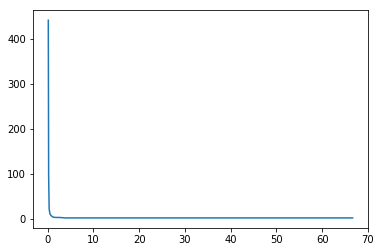

In [48]:
plt.plot(gamma_exp, T_exp)
#plt.plot([opt_point, opt_point], [0, max(T_exp)], )
#plt.figure()
#for i in range(1, 11):
#    plt.plot(epss[i-1], ts[i-1], label="gamma=%d"%(i*i,))
#leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
#leg.get_frame().set_alpha(0.5)
#plt.show()

In [65]:
gammas


array([[0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1 

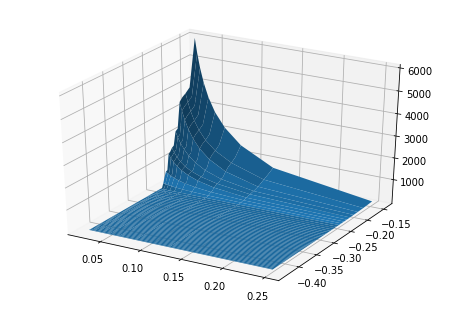

In [85]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(gammas, epss, ts)#, cmap = cm.jet)

pylab.show()

In [86]:
np.save("gammas.npy", gammas)
np.save("epss.npy", epss)
np.save("ts.npy", ts)

In [82]:
exp(1/-0.4)

0.0820849986238988